### Test the trained AutoEncoder

In [1]:
!pip install  tensorboard==2.10.0


   ---------------------------------------- 0.0/5.9 MB ? eta -:--:--
   ------- -------------------------------- 1.0/5.9 MB 32.3 MB/s eta 0:00:01
   ------- -------------------------------- 1.0/5.9 MB 32.3 MB/s eta 0:00:01
   -------------- ------------------------- 2.1/5.9 MB 16.6 MB/s eta 0:00:01
   -------------- ------------------------- 2.1/5.9 MB 16.6 MB/s eta 0:00:01
   -------------------- ------------------- 3.1/5.9 MB 13.9 MB/s eta 0:00:01
   --------------------- ------------------ 3.1/5.9 MB 12.5 MB/s eta 0:00:01
   ---------------------------- ----------- 4.2/5.9 MB 13.3 MB/s eta 0:00:01
   ---------------------------- ----------- 4.2/5.9 MB 13.3 MB/s eta 0:00:01
   ----------------------------------- ---- 5.2/5.9 MB 12.9 MB/s eta 0:00:01
   ----------------------------------- ---- 5.2/5.9 MB 12.9 MB/s eta 0:00:01
   ---------------------------------------- 5.9/5.9 MB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/195.5 kB ? eta -:--:--
   ----------

In [2]:
!pip install setuptools==59.5.0


   ---------------------------------------- 0.0/952.4 kB ? eta -:--:--
   --------------------------------------- 952.4/952.4 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.5.1
    Uninstalling setuptools-69.5.1:
      Successfully uninstalled setuptools-69.5.1


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
#from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from pathlib import Path
import random
from datetime import datetime

from matplotlib import pyplot as plt

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import KTHDataset, BAIRDataset, MovingMNISTDataset
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training
from utils import set_seed, get_dataloader

set_seed(2021)

c:\Users\sc23gd\.conda\envs\VPTR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np
import torch
from MovingMNIST import MovingMNIST
from pathlib import Path


In [8]:
resume_ckpt = Path('C:\\VPTR_jigsaws\\MovingMNIST\\MovingMNIST_AE.tar') #specify your trained autoencoder checkpoint file
num_past_frames = 10
num_future_frames = 10
encH, encW, encC = 8, 8, 528
img_channels = 1 #Set to be 3 for BAIR dataset
N = 16
device = torch.device('cuda:0')
loss_name_list = ['AE_L1', 'Dtotal', 'Dfake', 'Dreal', 'AEgan']

In [9]:
VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3, padding_type = 'reflect').to(device) #Set the padding_type to be "zero" for BAIR dataset

#Set the padding_type to be "zero" for BAIR dataset, set the out_layer to be 'Sigmoid' for MovingMNIST
VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Sigmoid', padding_type = 'reflect').to(device) 

init_weights(VPTR_Enc)
init_weights(VPTR_Dec)

loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, 
                                         {}, resume_ckpt, loss_name_list)

initialize network with normal
initialize network with normal


In [11]:
_, _, test_loader, renorm_transform = get_dataloader('MNIST', N, 'C:\\VPTR_jigsaws\\moving-mnist-example', test_past_frames = 10, test_future_frames = 10, ngpus = 1, num_workers = 12)

In [12]:
model = nn.Sequential(VPTR_Enc, VPTR_Dec)

In [14]:
sample = next(iter(test_loader))
past_frames, future_frames = sample
past_frames = past_frames.to(device)
future_frames = future_frames.to(device)
x = torch.cat([past_frames, future_frames], dim = 1 )
pred = model(x)

In [15]:
def plot_model_result(pred, fig_name, num_frames, n = 2):
    fig, ax = plt.subplots(1, num_frames, figsize = (num_frames, 1))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for j in range(num_frames):
        ax[j].set_axis_off()
        
        img = pred[:, j, :, :, :].clone()
        img = renorm_transform(img)
        img = torch.clamp(img, min = 0., max = 1.)
        img = img[n, ...]

        img = transforms.ToPILImage()(img)
        ax[j].imshow(img, cmap = 'gray')
    fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')

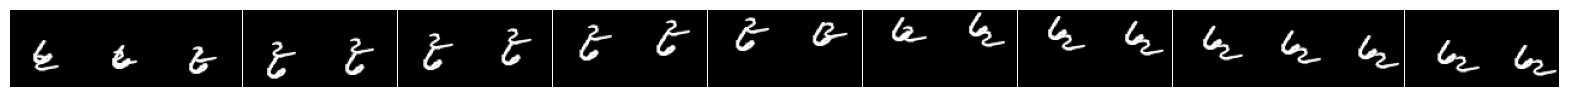

In [16]:
plot_model_result(x, 'AE_gt', 20, n = 1)

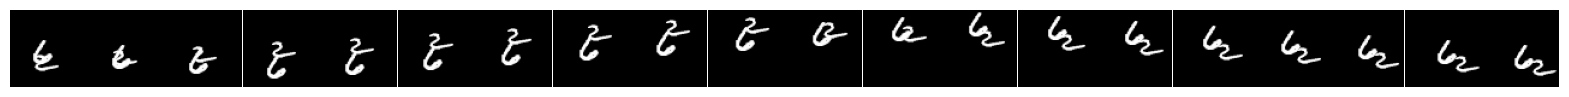

In [17]:
plot_model_result(pred, 'AE_rec', 20, n = 1)